In [1]:
# This example demonstrates the compilation of quantum programs using qstack.
# Compilation is the process of transforming a high-level quantum program into a lower-level representation suitable for execution.
# The Toy layer is a simplified abstraction layer for quantum operations, useful for prototyping and testing.
# It uses gates with names that reflect the intention (e.g., Flip) instead of the mathematical operation (e.g., X).
# It provides basic quantum gates and operations to define quantum programs.
import logging

# Set up logging to monitor the execution of the program.
logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)


In [2]:
# Import necessary components from qstack.
from qstack.ast import QubitId
from qstack.layers.toy import *
from qstack import Program, Stack, Kernel
from qstack.classic_processor import ClassicalContext


# Define a classical callback function for flipping a qubit's state.
def fix(context: ClassicalContext, *, q: QubitId):
    return Kernel(targets=[], instructions=[Flip(q)])


# Extend the layer with the classical definition for the fix operation.
Fix = ClassicDefinition.from_callback(fix)
layer = layer.extend_with(classic={Fix})

# Create a stack using the extended layer.
stack = Stack.create(layer)

# Define a quantum program with nested allocations and operations.
original = Program(
    stack=stack,
    kernels=[
        Kernel.allocate(
            "q1",  # Allocate the first qubit.
            compute=[
                Kernel.allocate(
                    "q2",  # Allocate the second qubit.
                    "q3",  # Allocate the third qubit.
                    compute=[
                        Mix("q2"),  # Apply a mixing operation to the second qubit.
                        Flip("q3"),  # Flip the state of the third qubit.
                    ],
                    continue_with=Fix(q="q1"),  # Apply the fix operation to the first qubit.
                )
            ],
        )
    ],
)

# Print the original program to visualize its structure.
print(original)


@stack: toy.extended

allocate q1:
  allocate q2 q3:
    mix q2
    flip q3
  measure
  ?? fix(q=q1)
measure


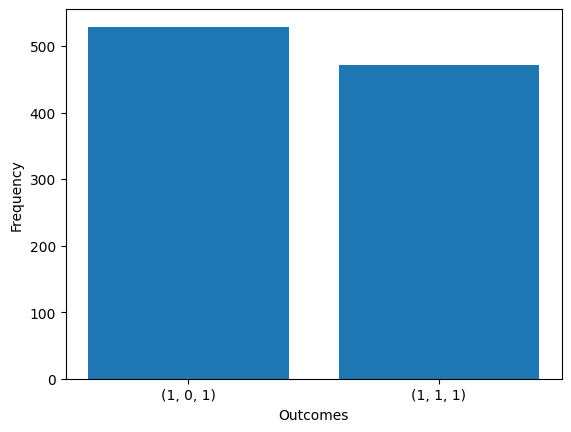

In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for

machine = local_machine_for(original.stack)

# Evaluate the original program and plot the resulting histogram.
machine.eval(original).plot_histogram()


In [4]:
# Compile the program using the ToyCompiler.
# The ToyCompiler transforms the program into a lower-level representation.
from qstack.compilers.toy2cliffords import ToyCompiler

compiler = ToyCompiler()
compiled = compiler.compile(original)

# Print the compiled program to see the transformed representation.
print(compiled)


2025-05-08 16:52:43,683 - WARNING - Instruction skew has no handler.


@stack: cliffords-min@toy2cliffords@l0:toy.extended

allocate q1:
  allocate q2 q3:
    h q2
    x q3
  measure
  ?? l0:fix(q=q1)
measure


In [5]:
# Attempt to evaluate the compiled program using the original machine.
# This will fail because the machine is configured for the original stack.
try:
    machine.eval(compiled).plot_histogram()
except Exception as e:
    print(e)
    print("This is expected, as the machine is for the original stack...")


Invalid instruction: h q2
This is expected, as the machine is for the original stack...


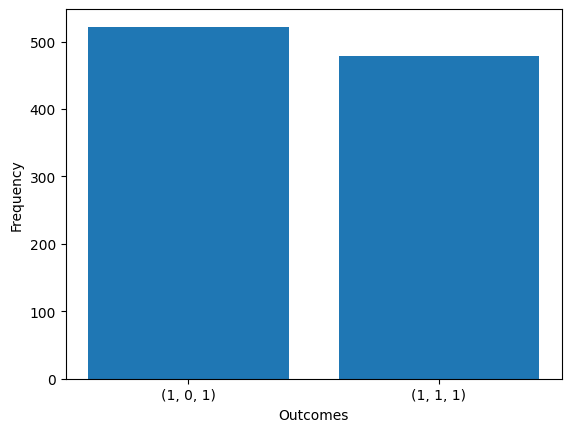

In [6]:
# Set up a new machine for the compiled program's stack and evaluate it.
machine = local_machine_for(compiled.stack)
machine.eval(compiled).plot_histogram()


In [7]:
# Compile the program further using the TrivialRepetitionCompiler.
# This compiler applies a simple repetition code for error correction.
from qstack.compilers.rep3_trivial import TrivialRepetitionCompiler

compiler = TrivialRepetitionCompiler()
rep3 = compiler.compile(compiled)

# Print the program after applying the repetition code.
print(rep3)


2025-05-08 16:52:43,858 - WARNING - Instruction cx has no handler.
2025-05-08 16:52:43,859 - WARNING - Instruction cz has no handler.
2025-05-08 16:52:43,861 - WARNING - Instruction z has no handler.
2025-05-08 16:52:43,862 - WARNING - Instruction y has no handler.


@stack: cliffords+decoder@rep3_toy@l1:cliffords-min@toy2cliffords@l0:toy.extended

allocate q1.0 q1.1 q1.2:
  ---
  ---
  allocate q2.0 q2.1 q2.2:
    allocate q3.0 q3.1 q3.2:
      ---
      ---
      h q2.0
      h q2.1
      h q2.2
      ---
      x q3.0
      x q3.1
      x q3.2
    measure
    ?? decode
  measure
  ?? decode
  ?? l0:fix(q=q1)
measure
?? decode


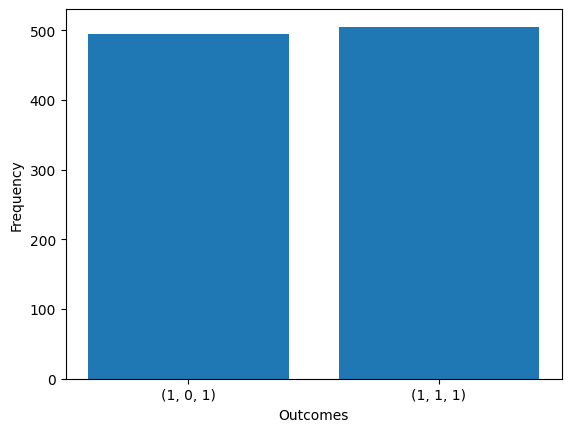

In [8]:
# Set up a machine for the repetition-coded program and evaluate it.
machine = local_machine_for(rep3.stack)
machine.eval(rep3).plot_histogram()


In [9]:
# Apply the repetition code again to the program.
rep3bis = compiler.compile(rep3)

# Print the program after the second application of the repetition code.
print(rep3bis)


@stack: cliffords+decoder@rep3_toy@l2:cliffords+decoder@rep3_toy@l1:cliffords-min@toy2cliffords@l0:toy.extended

---
allocate q1.0.0 q1.0.1 q1.0.2:
  allocate q1.1.0 q1.1.1 q1.1.2:
    allocate q1.2.0 q1.2.1 q1.2.2:
      ---
      ---
      ---
      ---
      ---
      allocate q2.0.0 q2.0.1 q2.0.2:
        allocate q2.1.0 q2.1.1 q2.1.2:
          allocate q2.2.0 q2.2.1 q2.2.2:
            ---
            ---
            allocate q3.0.0 q3.0.1 q3.0.2:
              allocate q3.1.0 q3.1.1 q3.1.2:
                allocate q3.2.0 q3.2.1 q3.2.2:
                  ---
                  ---
                  ---
                  ---
                  h q2.0.0
                  h q2.0.1
                  h q2.0.2
                  ---
                  h q2.1.0
                  h q2.1.1
                  h q2.1.2
                  ---
                  h q2.2.0
                  h q2.2.1
                  h q2.2.2
                  ---
                  ---
                  x q3.0.0
    

In [10]:
# A single-shot execution runs the program once and returns the measurement outcomes.
# This is useful for observing the result of a single execution of the quantum program.

# logger.setLevel(logging.DEBUG)

# machine = local_machine_for(rep3bis.stack)
# machine.single_shot(rep3bis)
